In [63]:
import os
from functions import *
import networkx as nx

In [20]:
path = 'GoT_files'

pages = os.listdir(path)
page_titles = [f for f in pages if not f.startswith('fetched_pages_')]
page_titles = [f for f in page_titles if not f.startswith('redirects_')]
page_titles = [f for f in page_titles if not f.startswith('failed_pages_')]

In [21]:
page_texts = load_all_files()

In [22]:
# print(page_texts['A Golden Crown (short)'])

In [26]:
page_links = {}

for page in page_texts.keys():
    file = page + '.txt'

    links = get_links(file)

    page_links[page] = links

In [27]:
page_links['A Golden Crown (short)']

['[[The Wolf and the Lion (short)|The Wolf and the Lion]]',
 '[[You Win or You Die (short)|You Win or You Die]]',
 '[[Game of Thrones: Inside the Episode: Season 1|first season]]',
 '[[Game of Thrones: Inside the Episode]]',
 '[[D.B. Weiss]]',
 '[[David Benioff]]',
 '[[Daniel Minahan]]',
 '[[Category:Shorts of Game of Thrones: Inside the Episode: Season 1| 06]]',
 '[[Category:Shorts released in 2011|5.24]]']

In [30]:
test = page_texts['A Golden Crown (short)']
print(test[:100])

{{DISPLAYTITLE:A Golden Crown {{C|short}}}}
{{Short
| Title    = A Golden Crown
| Type     = Thrones


In [62]:
matches = get_links('A Golden Crown (short).txt')
matches

['[[The Wolf and the Lion (short)|The Wolf and the Lion]]',
 '[[You Win or You Die (short)|You Win or You Die]]',
 '[[Game of Thrones: Inside the Episode: Season 1|first season]]',
 '[[Game of Thrones: Inside the Episode]]',
 '[[D.B. Weiss]]',
 '[[David Benioff]]',
 '[[Daniel Minahan]]',
 '[[Category:Shorts of Game of Thrones: Inside the Episode: Season 1| 06]]',
 '[[Category:Shorts released in 2011|5.24]]']

In [61]:
def clean_links(matches, category_map):
    categories = []
    links = []
    for m in matches:
        m = m.replace('[','').replace(']','')
        if 'Category:' in m:
            categories.append(m.replace('Category:',''))
            
        elif 'category:' in m:
            categories.append(m.replace('category:',''))
        else:
            if '|' in m:
                links.append(m.split('|')[0])
            else:
                links.append(m)
    categories = clean_categories(categories,category_map)

    return links, categories
    


In [103]:
DG = nx.DiGraph()
# for page in page_texts.keys():
#     DG.add_node(page)

In [104]:
page_links = {}
page_categories = {}

category_map = load_category_mapping()
for page in page_texts.keys():
    DG.add_node(page)
    matches = get_links(page+'.txt')
    links, categories = clean_links(matches,category_map)

    page_links[page] = links
    page_categories[page] = categories


In [105]:
for page in page_texts.keys():
    for link in page_links[page]:
        if link in list(DG.nodes()):
            DG.add_edge(page,link)
    for link in page_categories[page]:
        if link in list(DG.nodes()):
            DG.add_edge(page,link)

In [106]:
len(DG.edges())

201180

In [95]:
# Debug: Check if links are matching node names
test_page = 'Jon Snow'
print(f"Links for {test_page}:")
print(page_links[test_page][:10])
print(f"\nFirst 10 nodes in graph:")
print(list(DG.nodes())[:10])
print(f"\nDo any links match nodes?")
for link in page_links[test_page][:5]:
    print(f"  '{link}' in nodes: {link in DG.nodes()}")
print(f"\nTotal nodes: {len(DG.nodes())}")
print(f"Total edges: {len(DG.edges())}")

Links for Jon Snow:
['281 AC', 'Tower of Joy', 'Dorne', '302 AC', 'Castle Black', 'Gift', 'House Targaryen', 'House Stark', "Night's Watch", "Lord Commander of the Night's Watch"]

First 10 nodes in graph:
['A Golden Crown (short)', 'A Golden Crown', 'A Golden Crown_Appearances', 'A Knight of the Seven Kingdoms (disambiguation)', 'A Knight of the Seven Kingdoms (Game of Thrones)', 'A Knight of the Seven Kingdoms (Game of Thrones)_Appearances', 'A Knight of the Seven Kingdoms (short)', 'A Knight of the Seven Kingdoms (The Game Revealed)', 'A Knight of the Seven Kingdoms', 'A Knight of the Seven Kingdoms_ Season 1, Episode 1']

Do any links match nodes?
  '281 AC' in nodes: False
  'Tower of Joy' in nodes: True
  'Dorne' in nodes: True
  '302 AC' in nodes: False
  'Castle Black' in nodes: True

Total nodes: 5709
Total edges: 201180


In [117]:
largest_cc = max(nx.strongly_connected_components(DG), key=len)
DG_sub = DG.subgraph(largest_cc).copy()

bet_cent = nx.betweenness_centrality(DG_sub)
bet_cent = {k: v for k, v in sorted(bet_cent.items(), key=lambda item: item[1])}


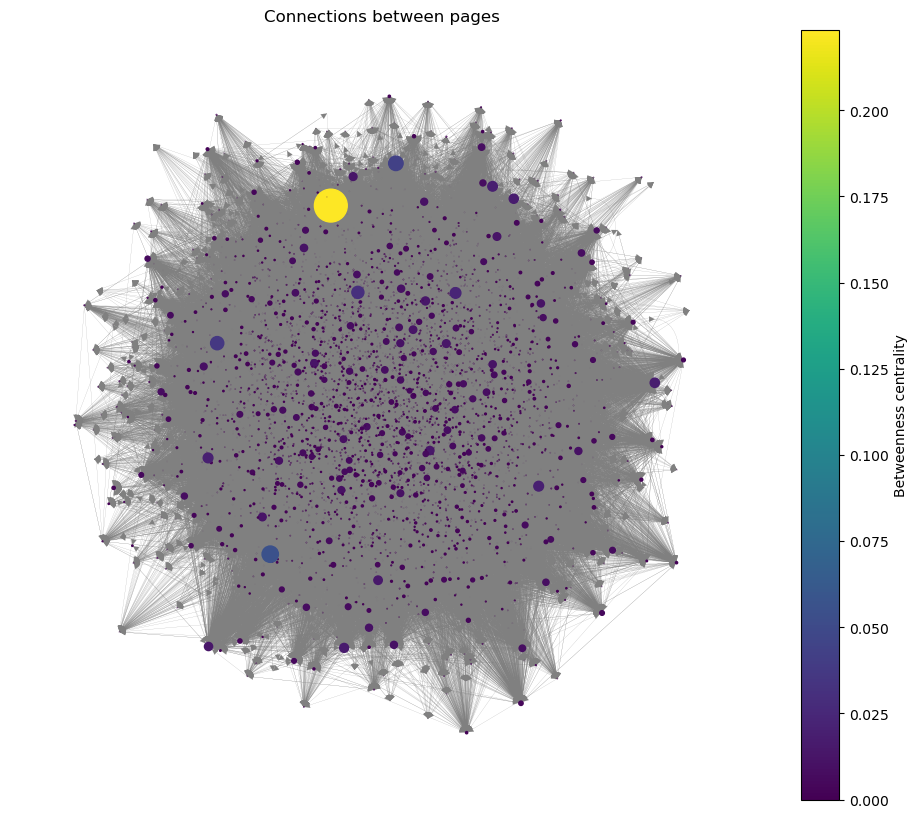

In [118]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib as mpl

deg = dict(DG_sub.degree())
node_sizes = [bet_cent[n]*2500 for n in DG_sub.nodes()]
bet_cent_vals = [bet_cent[n] for n in DG_sub.nodes()]

# compute layout once
pos = nx.forceatlas2_layout(DG_sub)

fig, ax = plt.subplots(figsize=(12, 10))

nx.draw(DG_sub, pos, 
        node_size=node_sizes,   
        node_color=bet_cent_vals,   
        cmap=plt.cm.viridis,   
        ax=ax, 
        edge_color='grey',
        width=0.1)

sm = mpl.cm.ScalarMappable(cmap=plt.cm.viridis, 
                           norm=mpl.colors.Normalize(vmin=min(bet_cent_vals), vmax=max(bet_cent_vals)))
sm.set_array(bet_cent_vals)
fig.colorbar(sm, ax=ax, label='Betweenness centrality')

ax.set_title('Connections between pages')
ax.axis('off')
plt.show()

In [122]:
# Find node with highest betweenness centrality (largest node size)
max_bet_node = max(bet_cent, key=bet_cent.get)
print(f"Node with largest size: {max_bet_node}")
print(f"Betweenness centrality: {bet_cent[max_bet_node]}")
print(f"Node size: {bet_cent[max_bet_node] * 2500}")

# Or get top 10
sorted_bet = sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 nodes by betweenness centrality:")
for i, (node, bc) in enumerate(sorted_bet[:10], 1):
    print(f"{i}. {node}: {bc:.6f}")

Node with largest size: Game of Thrones
Betweenness centrality: 0.22342196056263153
Node size: 558.5549014065788

Top 10 nodes by betweenness centrality:
1. Game of Thrones: 0.223422
2. House of the Dragon: 0.055410
3. A Song of Ice and Fire: 0.043457
4. House Targaryen: 0.036184
5. The Lineages and Histories of the Great Houses of the Seven Kingdoms: 0.030145
6. The Bells: 0.023498
7. House Stark: 0.019629
8. Daenerys Targaryen: 0.019606
9. Faith of the Seven: 0.019137
10. King's Landing: 0.017834


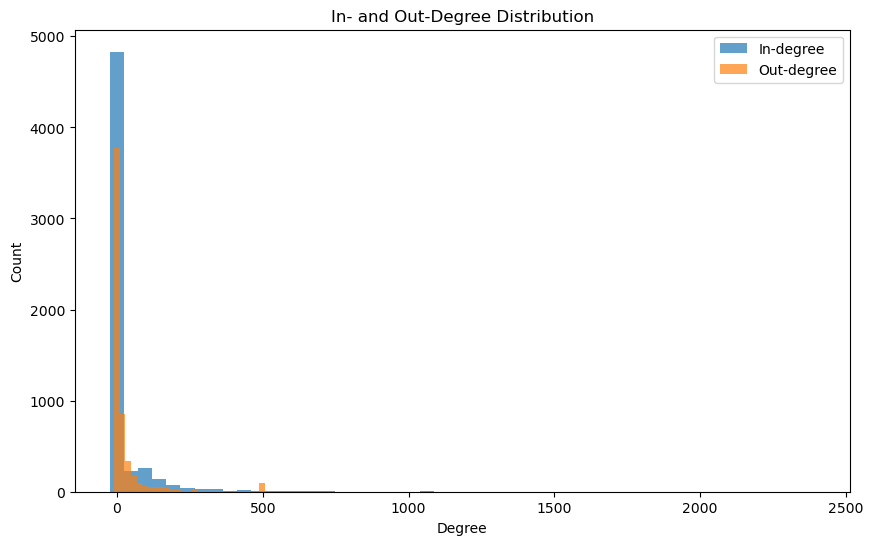

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Get in-degrees
in_degrees = [DG.in_degree(node) for node in DG.nodes()]
out_degrees = [DG.out_degree(node) for node in DG.nodes()]

# Create histogram with numpy
counts_in, bins_in = np.histogram(in_degrees, bins=50)
counts_out, bins_out = np.histogram(out_degrees, bins=50)

# Plot with matplotlib
plt.figure(figsize=(10, 6))
plt.bar(bins_in[:-1], counts_in, width=np.diff(bins_in), alpha=0.7)
plt.bar(bins_out[:-1], counts_out, width=np.diff(bins_out), alpha=0.7)
plt.legend(['In-degree', 'Out-degree'])
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('In- and Out-Degree Distribution')
plt.show()

In [121]:
import os
import pickle

os.makedirs('graphs', exist_ok=True)

# Save graphs
with open(os.path.join('graphs', 'dg.pickle'), 'wb') as f:
    pickle.dump(DG, f)

with open(os.path.join('graphs', 'dg_sub.pickle'), 'wb') as f:
    pickle.dump(DG_sub, f)

# Verify by loading dg_sub and printing counts
with open(os.path.join('graphs', 'dg_sub.pickle'), 'rb') as f:
    dg_sub_loaded = pickle.load(f)

print("dg_sub_loaded nodes, edges:", dg_sub_loaded.number_of_nodes(), dg_sub_loaded.number_of_edges())

dg_sub_loaded nodes, edges: 4690 119248


In [83]:
'Sansa Stark' in page_links['Jon Snow']

True

In [72]:
"303 AC" in list(DG.nodes())

False

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib as mpl

# 1) Prepare graph (convert to undirected and take largest connected component)
# DG = DG.to_undirected()
# optionally remove isolated nodes first (if you haven't already)
largest_cc = max(nx.connected_components(DG), key=len)
DG_sub = DG.subgraph(largest_cc).copy()


# DG_sub prepared earlier
deg = dict(DG_sub.degree())
node_sizes = [deg[n] * 30 + 20 for n in DG_sub.nodes()]
content_vals = [DG_sub.nodes[n].get('content_length', 0) for n in DG_sub.nodes()]

cmap = plt.cm.viridis
vmin, vmax = min(content_vals), max(content_vals)

# compute layout once
pos = nx.spring_layout(DG_sub, seed=42)

# create figure and axes explicitly
fig, ax = plt.subplots(figsize=(12, 10))

# draw on that axes
nx.draw_networkx_edges(DG_sub, pos, ax=ax, alpha=0.3, edge_color='gray', width=0.5)
nodes = nx.draw_networkx_nodes(DG_sub, pos,
                               node_size=node_sizes,
                               node_color=content_vals,
                               cmap=cmap,
                               vmin=vmin,
                               vmax=vmax,
                               ax=ax)

# create ScalarMappable for colorbar and attach to the figure, using the same ax
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm.set_array(content_vals)
fig.colorbar(sm, ax=ax, label='content_length (words)')

ax.set_title('Connections between pages')
ax.axis('off')
plt.show()